# `Problem 1`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-dark')
 
from sqlalchemy import create_engine,text
user = 'root'
passwords = '7003890541'
host = 'localhost'
port = 3306
database = 'synthea'

engine = create_engine(f"mysql+pymysql://{user}:{passwords}@{host}:{port}/{database}")
def sql(query , engine = engine):
    return pd.read_sql(query,engine)


def select(table_name):
    return sql(f'select * from {table_name} limit 5')


def run(query):
    with engine.connect() as con:
        con.execute(text(query))
        con.commit()

In [3]:
sql('SELECT * FROM DATA LIMIT 1')

,id,start,stop,patient,organization,provider,payer,class,description,basic_cost,total_cost,payer_coverage,reason,readmission
0,d0c40d10-8d87-447e-836e-99d26ad52ea5,2010-01-23 17:45:28,2010-01-23 18:10:28,034e9e3b-2def-4559-bb2a-7850888ae060,e002090d-4e92-300e-b41e-7d1f21dee4c6,e6283e46-fd81-3611-9459-0edb1c3da357,6e2f1a2d-27bd-3701-8d08-dae202c58632,ambulatory,encounter for symptom,129.16,129.16,54.16,acute bronchitis (disorder),0


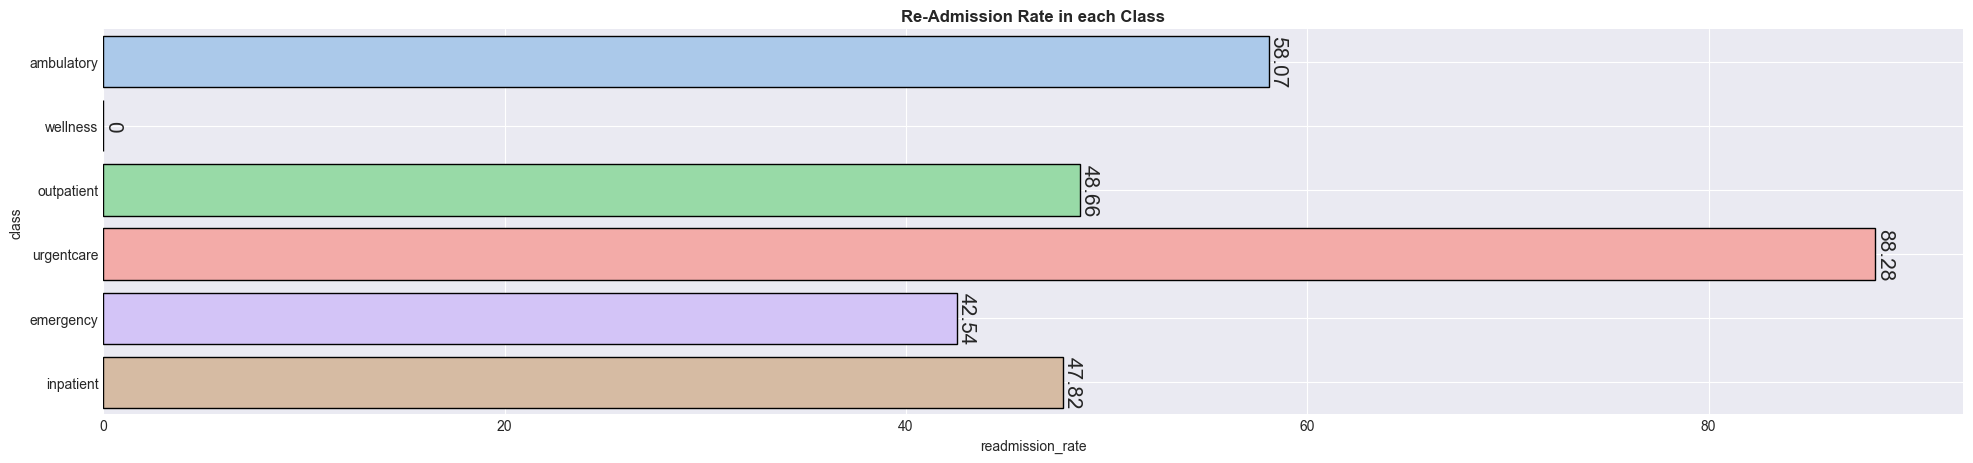

In [50]:
query = '''
    select 
    class,
    round(100*(sum(readmission = '1')/count(*)),2) as readmission_rate
    from data
    group by class
'''

df = sql(query)
plt.figure(figsize=(24,5))
ax = sns.barplot(x = 'readmission_rate',y='class',data=df,palette='pastel',edgecolor= 'black')
for container in ax.containers:
    ax.bar_label(container,fontsize= 15,rotation = -90)
plt.title('Re-Admission Rate in each Class',weight = 'bold')
plt.grid()
plt.show()

`URGENT CARE HAVE THE HIGHEST READMISSION RATE`